Necessary Imports

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.models import load_model

Load the Dataset

In [40]:
df = pd.read_csv("/content/nepali_sentences.csv")
faqs = df['Sentence'].astype(str).tolist()

Tokenize Text

In [41]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(faqs)  # We directly fit the tokenizer on the list
total_words = len(tokenizer.word_index) + 1  # +1 for the padding token

# Convert the text into sequences of tokens
input_sequences = []
for line in faqs:  # Loop over the list directly
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

Pad sequences to have uniform length

In [42]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

Split data into predictors (X) and label (y)

In [43]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

Build the LSTM model

In [44]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Compile the model

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [46]:
history = model.fit(X, y, epochs=20, verbose=1)
# Save the model after training
model.save('nepali_language_model.h5')

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.0646 - loss: 5.2256
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3999 - loss: 2.7069
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7705 - loss: 1.1307
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7943 - loss: 0.7267
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7894 - loss: 0.6535
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8000 - loss: 0.5966
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7907 - loss: 0.5937
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7963 - loss: 0.5657
Epoch 9/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7939 - loss: 0.5717
Epoch 10/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7902 - loss: 0.5663
Epoch 11/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7988 - loss: 0.5608
Epoch 12/20
301/301 ━━━━━━━━━━━━━━━━━

In [47]:
# Load the model before making predictions
model = load_model('nepali_language_model.h5')

Next Word Prediction Function

In [48]:
#Version 1
def predict_next_word(model, tokenizer, text, max_sequence_len):
    # Start with the seed text
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted_probs)

    # Map the predicted index back to the corresponding word
    predicted_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            predicted_word = word
            break

    return predicted_word


In [49]:
#Version 2
def predict_next_words(model, tokenizer, text, max_sequence_len, top_n=3):
    # Start with the seed text
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word probabilities
    predicted_probs = model.predict(token_list, verbose=0)

    # Get the indices of the top N words with the highest probability
    predicted_word_indices = np.argsort(predicted_probs[0])[::-1][:top_n]

    # Map the predicted indices back to words
    predicted_words = []
    for index in predicted_word_indices:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                predicted_words.append(word)
                break

    return predicted_words


Real-time Prediction

In [50]:
# Version 1
def predict_while_typing():
    sentence = ""
    print("Start typing (Type 'q' to quit): ")

    while True:
        # Take the user input (next word)
        input_text = input("Type next word: ")

        # Exit condition
        if input_text.lower() == 'q':
            break

        # Add typed input to the sentence
        sentence += " " + input_text

        # Predict the next word based on the current sentence
        predicted_word = predict_next_word(model, tokenizer, sentence, max_sequence_len)

        # Add predicted word to the sentence
        sentence += " " + predicted_word

        # Display the current sentence (typed + predicted)
        print(f"Current sentence: {sentence}")

# Run the real-time prediction
predict_while_typing()


Start typing (Type 'q' to quit): 
Type next word: q


In [51]:
#Version 2
def predict_while_typing():
    sentence = ""
    print("Start typing (Type 'q' to quit): ")

    while True:
        # Take the user input (next word)
        input_text = input("Type next word: ")

        # Exit condition
        if input_text.lower() == 'q':
            break

        # Add typed input to the sentence
        sentence += " " + input_text

        # Predict the next words based on the current sentence
        predicted_words = predict_next_words(model, tokenizer, sentence, max_sequence_len, top_n=3)

        # Display the predicted words and ask for the user's choice
        print(f"Predicted words:")
        for i, word in enumerate(predicted_words, 1):
            print(f"{i}. {word}")

        # Ask the user to select a word
        try:
            choice = int(input(f"Choose a word by number (1, 2, or 3): "))

            if choice not in [1, 2, 3]:
                print("Invalid choice. Please choose 1, 2, or 3.")
                continue  # Skip this loop iteration and let the user try again

            # Add the chosen word to the sentence
            sentence += " " + predicted_words[choice - 1]

        except ValueError:
            print("Please enter a valid number (1, 2, or 3).")
            continue  # Skip this loop iteration and let the user try again

        # Display the current sentence (typed + predicted)
        print(f"Current sentence: {sentence}")

# Run the real-time prediction
predict_while_typing()


Start typing (Type 'q' to quit): 
Type next word: q


Necessary Plots

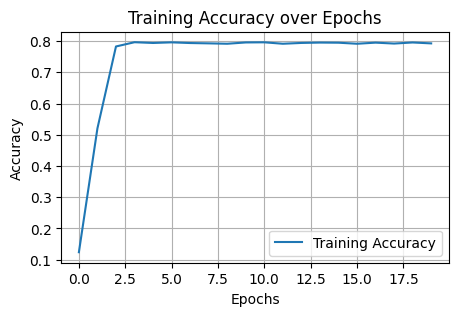

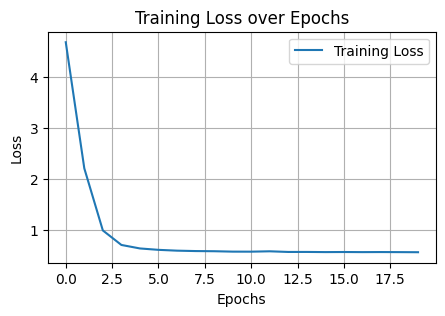

In [52]:
import matplotlib.pyplot as plt

# Plot 1: Training Accuracy Graph
def plot_accuracy(history):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Plot 2: Training Loss Graph
def plot_loss(history):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Calling the functions to plot graphs
plot_accuracy(history)
plot_loss(history)
